# Carga de archivos

In [1]:
import pandas as pd
from tqdm import tqdm
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import  drive
!pip install opencv-python
drive.mount('/drive')
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import numpy as np
import cv2
from skimage.draw import line_aa
from scipy.sparse import csr_matrix
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /drive


Obtengo los 12 binarios de frutas y verduras

In [2]:
downloaded = drive.CreateFile({'id':"16bbN-1G5ArZiqnLaWjYMg7iYMk-6uW6W"})   
downloaded.GetContentFile('full_binary_apple') 

downloaded = drive.CreateFile({'id':"1ajvbi8NANXOqBkszeXugO6QSsYNo00Ss"})   
downloaded.GetContentFile('full_binary_asparagus')

downloaded = drive.CreateFile({'id':"145RvJRKY8x7cvT85BASIiMER3eH1lATS"})   
downloaded.GetContentFile('full_binary_banana') 

downloaded = drive.CreateFile({'id':"1iaVjwTLTRj1y4GtaqU6mYcRkMJWr9A8S"})   
downloaded.GetContentFile('full_binary_blackberry')
 
downloaded = drive.CreateFile({'id':"1lAEyLxdlSspKPdOxipHzisJ2sAeOsk8T"})   
downloaded.GetContentFile('full_binary_blueberry') 

downloaded = drive.CreateFile({'id':"1Yi_qc_89ZfNfNw0tEccuZmt00kEXHfw1"})   
downloaded.GetContentFile('full_binary_broccoli')
 
downloaded = drive.CreateFile({'id':"1av_EgjFdLQGxaaAHRdooehJh8GybcpHi"})   
downloaded.GetContentFile('full_binary_grapes') 

downloaded = drive.CreateFile({'id':"1te9IdjAl1g5bo-9XVw4w3bpSeiSKoEFa"})   
downloaded.GetContentFile('full_binary_onion')
 
downloaded = drive.CreateFile({'id':"1jUOb3Di67nNuAl3RGLJB-qDS_9k5Gt1L"})   
downloaded.GetContentFile('full_binary_pineapple') 

downloaded = drive.CreateFile({'id':"1hNa5nqFaXo7yfpcujvvzXgJBsJ38mLQQ"})   
downloaded.GetContentFile('full_binary_potato')

downloaded = drive.CreateFile({'id':"1-R19uHx2Fr-RTfJNRTJfhTxrDzWD7TDc"})   
downloaded.GetContentFile('full_binary_strawberry') 

downloaded = drive.CreateFile({'id':"1don-lH8pJXelrutwypPLM1A_kts_gUMG"})   
downloaded.GetContentFile('full_binary_watermelon')
 
 

Funcion del repo para convertir los binarios a un dataframe

In [3]:
# Copyright 2017 Google Inc.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
# https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    country_code, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'recognized': recognized,
        'image': image
    }
        #'key_id': key_id,
        #'country_code': country_code,
        #'timestamp': timestamp,


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break




"Hiperparametros" generales del modelo, se puede agrandar el sample hasta 1769461 dibujos, segun la cantidad de procesamiento que tengas, yo llego hasta 100000. A su vez elegi estos 12 alimentos pero podes quitarlos a gusto

In [4]:
SampleSize = 100000
foods = ["apple","asparagus","banana","blackberry","blueberry","broccoli","grapes","onion","pineapple","potato","strawberry","watermelon"]

In [5]:
data = pd.DataFrame(columns=["image", "preds"])

Aca los agrupo a todos en un dataframe, y me quedo solamente con los dibujos que la IA de google reconocio

In [6]:
for food in tqdm(foods):
    df = pd.DataFrame(unpack_drawings('full_binary_' + food))
    df = df[df["recognized"] == 1][["image"]]
    df.loc[:, 'preds'] = food
    data = pd.concat([df, data], ignore_index=True)

100%|██████████| 12/12 [01:10<00:00,  5.88s/it]


In [7]:
data["length"] = data["image"].apply(lambda x: len(x)) #cantidad de trazos

In [10]:
data["length"].describe()

count    1.863044e+06
mean     4.978087e+00
std      4.605421e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      7.000000e+00
max      3.220000e+02
Name: length, dtype: float64

In [11]:
q_95 = data["length"].quantile(0.95) 

In [12]:
data = (data[data["length"] < q_95])

In [13]:
data = data.sample(SampleSize, random_state=42).reset_index()

In [14]:
del data["index"]
del data["length"]

In [17]:
data.iloc[23134][0][0]

((34, 10, 5, 5, 12, 29, 63, 93, 110, 115, 115, 112, 107, 82, 61),
 (90, 142, 186, 207, 225, 238, 242, 230, 215, 194, 156, 136, 128, 101, 87))

Funcion que une los trazos a rectas, generando la imagen

In [ ]:
def hacerImagen(trazos):
    m  = np.zeros((256,256))
    for i in range(len(trazos)):
        xAxis = trazos[i][0]
        yAxis = trazos[i][1]
        for j in range(len(xAxis) - 1):
            rr, cc, val = line_aa(xAxis[j], yAxis[j], xAxis[j+1], yAxis[j+1])
            m[rr, cc] = 1        
    return cv2.resize(m, dsize=(64,64), interpolation=cv2.INTER_CUBIC).reshape(-1)

In [ ]:
data.loc[:, "image"] = data["image"].apply(lambda x: hacerImagen(x))

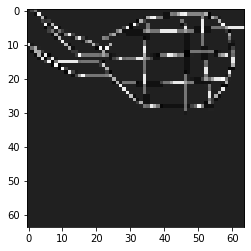

pineapple


In [ ]:
plt.imshow(data.iloc[23134][0].reshape((64,64)), cmap="gray")
plt.show()
print(data.iloc[23134][1])


Exportacion a mi drive

In [ ]:
pickle.dump(csr_matrix(np.array([r for r in data["image"]])), open("/drive/My Drive/Orga Datos/tp4/sparseImages", 'wb'), protocol=4)

In [ ]:
pickle.dump(data["preds"].values, open("/drive/My Drive/Orga Datos/tp4/labels", "wb"), protocol=4) 